# 2018 election

The main goal of this work is to identify the most important issues leading up into the election.

Our strategy is to
1. Gather all the politics articles from 2018.
2. Build a topic model for the year.
3. Track each of the topics throughout the year and study any changes as the election approaches.

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from sqlalchemy import create_engine, text

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import spacy

from joblib import dump, load

In [7]:
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["axes.titlesize"] = 30

We will use spaCy to tokenize the articles, remove stopwords, numbers, punctuations, spaces, and perform lemmatization.

In [101]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "NER"])

def spacy_tokenizer(doc):
    return [word.lemma_ for word in nlp(doc) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

# EDA

In [2]:
engine = create_engine("sqlite:///../data/news.db")

In [3]:
conn = engine.connect()

In [4]:
query = "SELECT publication, COUNT(*) AS num FROM articles GROUP BY publication ORDER BY num DESC"

results = conn.execute(text(query))

df_pub = pd.DataFrame(results.fetchall(), columns = results.keys())
df_pub.publication = df_pub.publication.where(~(df_pub.publication == ""), "Unknown")

Looking at the total number of articles per publication in the data set we see that most articles are from Reuters and some of them are unknown.

<BarContainer object of 27 artists>

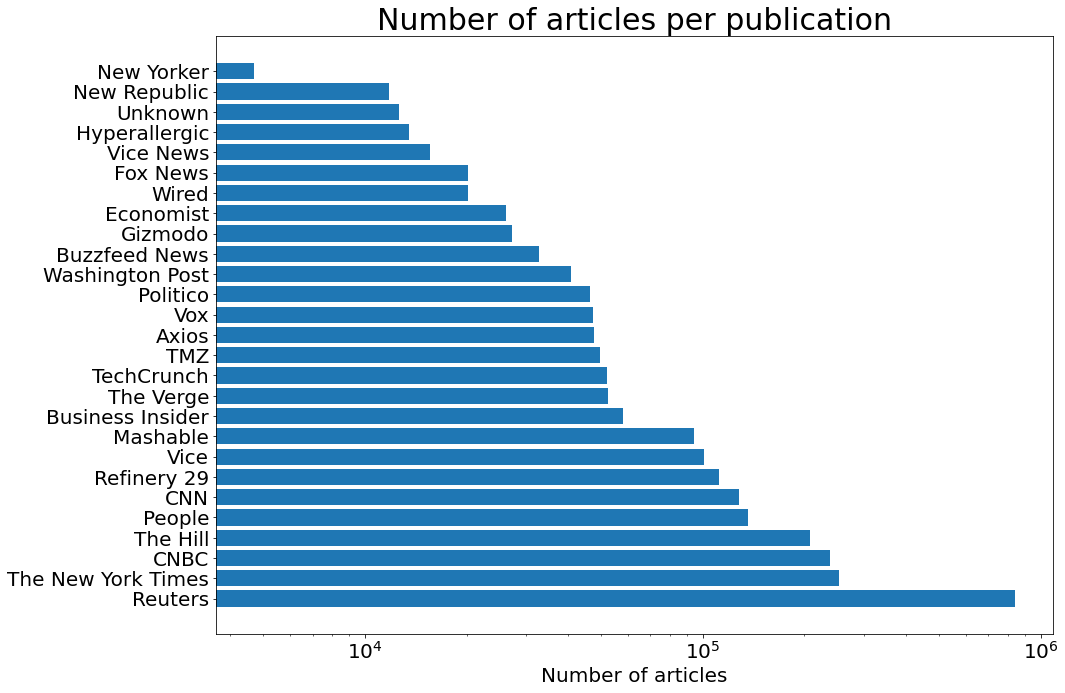

In [8]:
fig, ax = plt.subplots(figsize=(15,11))

ax.set_title("Number of articles per publication")
ax.set_xlabel("Number of articles")

ax.barh(df_pub.publication, width=df_pub.num, log=True)

---

In [11]:
query = "SELECT section, COUNT(*) AS num FROM articles GROUP BY section ORDER BY num DESC"

results = conn.execute(text(query))

df_sec = pd.DataFrame(results.fetchall(), columns = results.keys())

df_sec.section = df_sec.section.where(~(df_sec.section == ""), "Unknown")

The dataset contains articles from many different sections.

Importantly, there are at least two politics sections: "politics" and "Politics" as well as a unknown section with $\sim 10^6$ articles that may contain politics articles.

<BarContainer object of 20 artists>

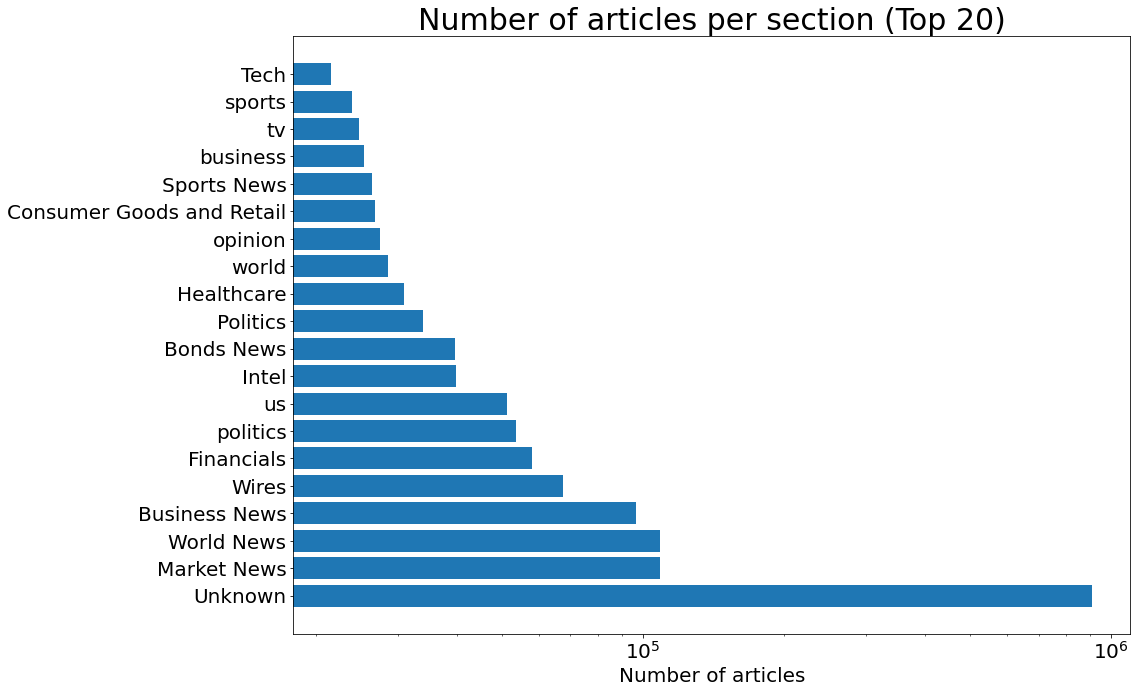

In [12]:
fig, ax = plt.subplots(figsize=(15,11))

ax.set_title("Number of articles per section (Top 20)")
ax.set_xlabel("Number of articles")

ax.barh(df_sec.section.head(20), width=df_sec.num.head(20), log=True)

Since we are interested in the politics articles, we can check which sections contain the string "politic", this will match "politics", "political", etc.

As we saw before, we will have to check for case-insensitive matches.

Most of them are in "politics" or "Politics" as expected but there are also smaller section for different countries as well as many other sections that seem to be connected with a specific article.

<BarContainer object of 20 artists>

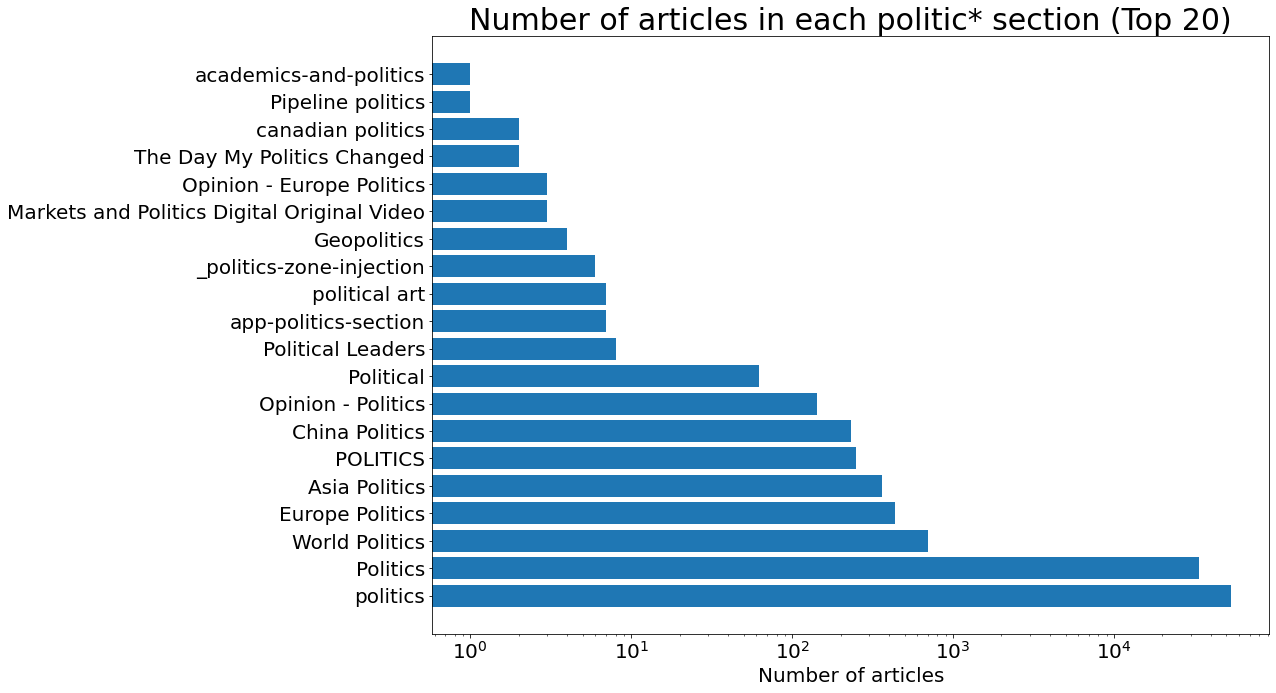

In [17]:
fig, ax = plt.subplots(figsize=(15,11))

ax.set_title("Number of articles in each politic* section (Top 20)")
ax.set_xlabel("Number of articles")

ax.barh(df_sec[df_sec.section.str.contains("politic", case=False)].head(20).section, width=df_sec[df_sec.section.str.contains("politic", case=False)].head(20).num, log=True)

---

In [9]:
query = "SELECT year, COUNT(*) AS num FROM articles GROUP BY year"

results = conn.execute(text(query))

df_year = pd.DataFrame(results.fetchall(), columns = results.keys())

The articles span the years 2016 - 2020 with the fewest number in 2020.

<BarContainer object of 5 artists>

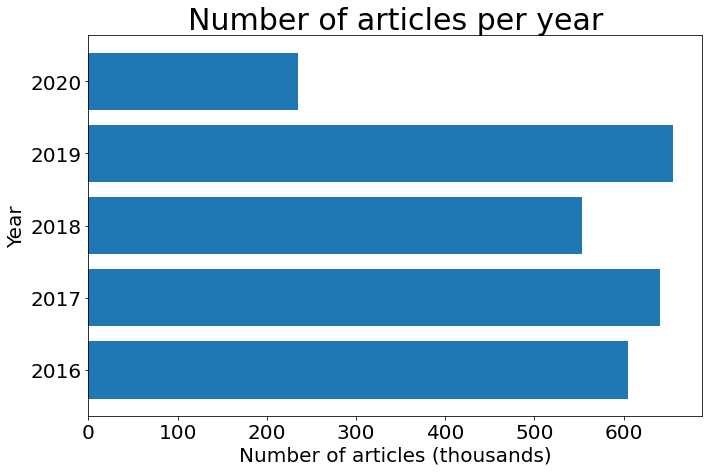

In [10]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Number of articles per year")
ax.set_xlabel("Number of articles (thousands)")
ax.set_ylabel("Year")

ax.barh(df_year.year, width=df_year.num/1000)

In [18]:
politics_sec = df_sec[df_sec.section.str.contains("politic", case=False)]
politics_sec.reset_index(drop=True, inplace=True)
politics_sec = politics_sec[politics_sec["num"] > 10]

In [20]:
df_politics_year = None

query = "SELECT year, COUNT(*) AS num FROM articles WHERE section = :sec GROUP BY year"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_year = pd.concat([df_politics_year, temp_df])

df_politics_year = df_politics_year.groupby("year").sum()

We can check how many articles are political articles for each year by going through the above politics sections. We can focus only on the sections with more than 10 articles.

There are only 5k politics article in 2020.

<BarContainer object of 5 artists>

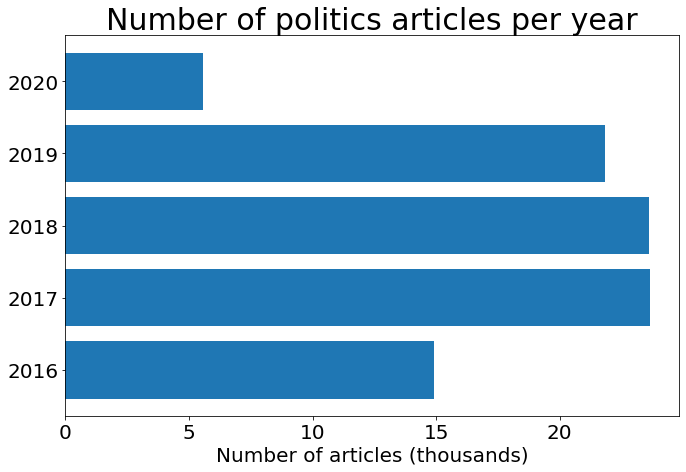

In [21]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Number of politics articles per year")
ax.set_xlabel("Number of articles (thousands)")

ax.barh(df_politics_year.index, width=df_politics_year.num/1000)

We will be focusing only on the 2018 politics articles since we are interested in studying the 2018 mid-term election.

In [23]:
df_politics_2018 = None

query = "SELECT * FROM articles WHERE year = 2018 AND section = :sec"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_2018 = pd.concat([df_politics_2018, temp_df])
#conn.close()

Most 2018 politics articles are from CNN.

<BarContainer object of 8 artists>

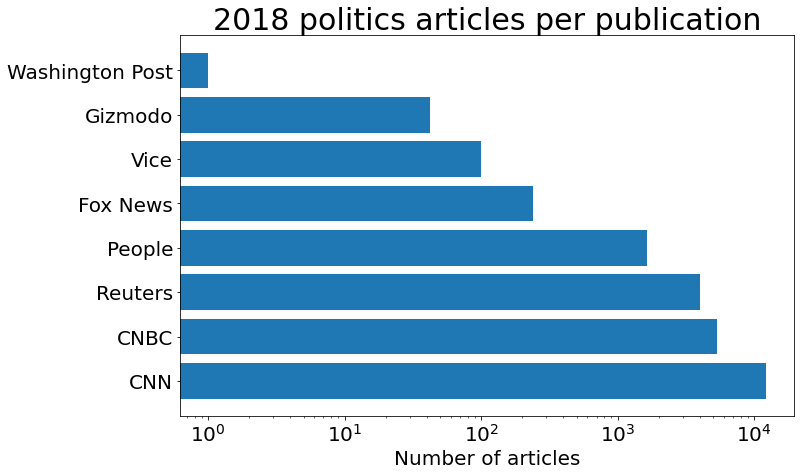

In [24]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2018 politics articles per publication")
ax.set_xlabel("Number of articles")

ax.barh(df_politics_2018.groupby("publication").count().sort_values(by="id", ascending=False).index, width=df_politics_2018.groupby("publication").count().sort_values(by="id", ascending=False)["id"], log=True)

We will also grab the unknown section articles from 2018. There are over 180k unlabeled articles.

In [25]:
query = "SELECT * FROM articles WHERE year = 2018 AND section = :sec"

results = conn.execute(text(query), {"sec": ''})
df_unk = pd.DataFrame(results.fetchall(), columns = results.keys())

In [26]:
len(df_unk)

180748

The unlabled articles are from a wide variety of publications some of which are not accounted for by the labeled articles.

We will want to build a classifier that can pick out the politics articles from the unlabeled dataset.

<BarContainer object of 20 artists>

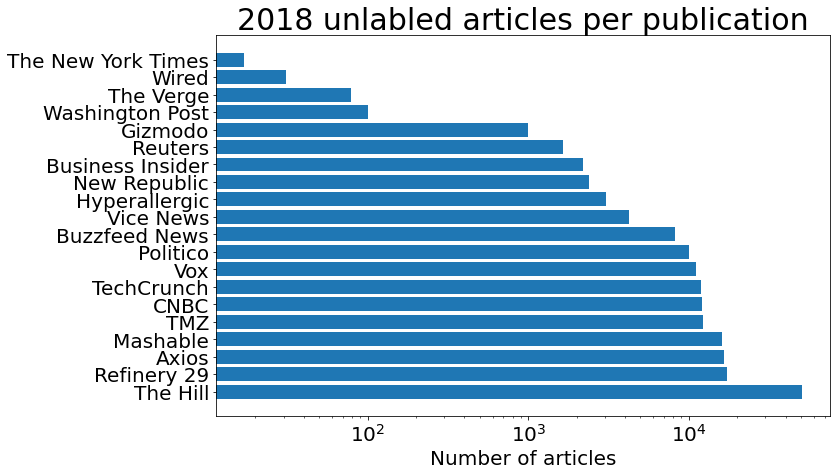

In [27]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2018 unlabled articles per publication")
ax.set_xlabel("Number of articles")

ax.barh(df_unk.groupby("publication").count().sort_values(by="id", ascending=False).index, width=df_unk.groupby("publication").count().sort_values(by="id", ascending=False)["id"], log=True)

To build the classifier we will need articles from other labeled sections. We will take 200 articles (only from 2018) from the top 20 sections.

In order to balance the dataset we will take 900 from the "politics" and 900 from the "Politics" sections. We should have about 2000 of politics and 2000 of not politics articles after the preprocessing step.

In [50]:
top_secs = df_sec.head(21)[1:].section.values
top_secs

array(['Market News', 'World News', 'Business News', 'Wires',
       'Financials', 'politics', 'us', 'Intel', 'Bonds News', 'Politics',
       'Healthcare', 'world', 'opinion', 'Consumer Goods and Retail',
       'Sports News', 'business', 'tv', 'sports', 'Tech', 'arts'],
      dtype=object)

In [84]:
df_top_20 = None

query = "SELECT * FROM articles WHERE year = 2018 AND section = :sec ORDER BY random() LIMIT :lim"

for s in top_secs:
    lim = 200
    if s == "politics" or s == "Politics":
        lim = 900
    results = conn.execute(text(query), {"sec": s, "lim": lim})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_top_20 = pd.concat([df_top_20, temp_df])
#conn.close()

<BarContainer object of 19 artists>

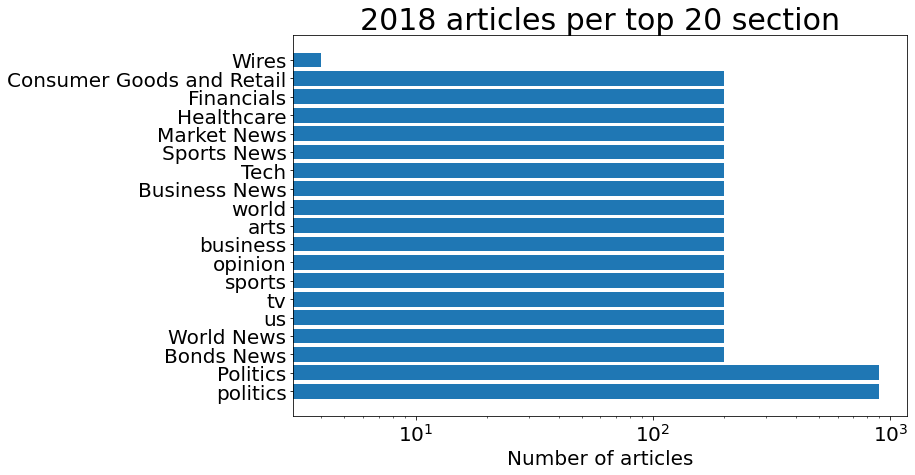

In [85]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2018 articles per top 20 section")
ax.set_xlabel("Number of articles")

ax.barh(df_top_20.groupby("section").count().sort_values(by="id", ascending=False).index, width=df_top_20.groupby("section").count().sort_values(by="id", ascending=False)["id"], log=True)

# Preprocessing

Next we turn to preprocessing. We will perform the preprocessing steps on 3 datasets:
- 2018 politics articles
- Top 20 sections from 2018 articles
- Unlabled articles

First, we will want to remove any articles that are empty or only contain whitespace.

In [29]:
(df_politics_2018.article == "").value_counts()
articles_to_drop = df_politics_2018[df_politics_2018.article == ""]
articles_to_drop

,id,date,year,month,day,author,title,article,url,section,publication
10016,973872,2018-08-22,2018,8,22,,The Cohen-Manafort fallout,,https://www.cnn.com/2018/08/22/politics/manafo...,politics,CNN
10803,978034,2018-09-18,2018,9,18,,Error,,https://www.cnn.com/2018/09/18/politics/kavana...,politics,CNN
10988,978955,2018-09-24,2018,9,24,,Latest news: Rod Rosenstein expects to be fired,,https://www.cnn.com/2018/09/24/politics/rod-ro...,politics,CNN
12808,990431,2018-11-18,2018,11,18,,Error,,https://www.cnn.com/2018/11/18/politics/young-...,politics,CNN
13728,996675,2018-12-19,2018,12,19,,Error,,https://www.cnn.com/2018/12/19/politics/europe...,politics,CNN


In [30]:
df_politics_2018.drop(articles_to_drop.index, inplace=True)
df_politics_2018.reset_index(drop=True, inplace=True)
(df_politics_2018.article == "").value_counts()

False    23602
Name: article, dtype: int64

In [35]:
(df_politics_2018.article == " ").value_counts()
articles_to_drop = df_politics_2018[df_politics_2018.article == " "]
articles_to_drop.head()

,id,date,year,month,day,author,title,article,url,section,publication


In [33]:
df_politics_2018.drop(articles_to_drop.index, inplace=True)
df_politics_2018.reset_index(drop=True, inplace=True)
(df_politics_2018.article == " ").value_counts()

False    23546
Name: article, dtype: int64

---

In [86]:
(df_top_20.article == "").value_counts()
articles_to_drop = df_top_20[df_top_20.article == ""]
articles_to_drop.head()

,id,date,year,month,day,author,title,article,url,section,publication
5,1214517,2018-05-03,2018,5,3,,PRECIOUS-Gold prices edge up ahead of U.S.-Sin...,,https://www.reuters.com/article/global-preciou...,Market News,Reuters
48,1273774,2018-09-07,2018,9,7,,"Morning News Call - India, September 7",,https://www.reuters.com/article/india-morningc...,Market News,Reuters
65,1216871,2018-01-10,2018,1,10,,PRECIOUS-Gold jumps on report China may slow U...,,https://www.reuters.com/article/global-preciou...,Market News,Reuters
67,751461,2018-05-23 00:00:00,2018,5,23,,"Morning News Call - India, May 23",,https://www.reuters.com/article/india-morningc...,Market News,Reuters
192,1000237,2018-03-02,2018,3,2,,UK Stocks-Factors to watch on March 2,,https://www.reuters.com/article/britain-stocks...,Market News,Reuters


In [87]:
df_top_20.drop(articles_to_drop.index, inplace=True)
df_top_20.reset_index(drop=True, inplace=True)
(df_top_20.article == "").value_counts()

False    4192
Name: article, dtype: int64

In [88]:
(df_top_20.article == " ").value_counts()
articles_to_drop = df_top_20[df_top_20.article == " "]
articles_to_drop.head()

,id,date,year,month,day,author,title,article,url,section,publication
1192,957332,2018-03-26,2018,3,26,Brian Ries,Trump expels Russian diplomats,,https://www.cnn.com/2018/03/26/politics/trump-...,politics,CNN
1376,950017,2018-02-01,2018,2,1,Meg Wagner,President Trump today: Live updates,,https://www.cnn.com/2018/02/01/politics/trump-...,politics,CNN
1378,956276,2018-03-13,2018,3,13,Meg Wagner,Trump is in California: Follow live,,https://www.cnn.com/2018/03/13/politics/trump-...,politics,CNN


In [89]:
df_top_20.drop(articles_to_drop.index, inplace=True)
df_top_20.reset_index(drop=True, inplace=True)
(df_top_20.article == " ").value_counts()

False    4189
Name: article, dtype: int64

---

In [37]:
(df_unk.article == "").value_counts()
articles_to_drop = df_unk[df_unk.article == ""]
articles_to_drop.head()

,id,date,year,month,day,author,title,article,url,section,publication
866,5793,2018-07-08 00:00:00,2018,7,8,,Sylvester Stallone Gets an Action Hero-Packed ...,,https://www.tmz.com/2018/07/08/sylvester-stall...,,TMZ
1311,8873,2018-07-10 00:00:00,2018,7,10,,Justin Bieber and Hailey Baldwin Return to NYC...,,https://www.tmz.com/2018/07/10/justin-bieber-h...,,TMZ
1357,9135,2018-01-30 23:04:28,2018,1,30,Matthew DeBord,Harley-Davidson to launch electric motorcycle ...,,https://www.businessinsider.com/harley-davidso...,,Business Insider
5321,35784,2018-09-16 00:00:00,2018,9,16,,"Vile, Disgusting, Shocking Dolphin Kill on the...",,https://www.tmz.com/2018/09/16/killing-dolphin...,,TMZ
8255,55481,2018-02-18 00:00:00,2018,2,18,,Kate Middleton Breaks BAFTA's Time's Up All-Bl...,,https://www.tmz.com/2018/02/18/kate-middleton-...,,TMZ


In [38]:
df_unk.drop(articles_to_drop.index, inplace=True)
df_unk.reset_index(drop=True, inplace=True)
(df_unk.article == "").value_counts()

False    178277
Name: article, dtype: int64

In [39]:
(df_unk.article == " ").value_counts()
articles_to_drop = df_unk[df_unk.article == " "]
articles_to_drop.head()

,id,date,year,month,day,author,title,article,url,section,publication


In [40]:
df_unk.drop(articles_to_drop.index, inplace=True)
df_unk.reset_index(drop=True, inplace=True)
(df_unk.article == " ").value_counts()

False    178277
Name: article, dtype: int64

---

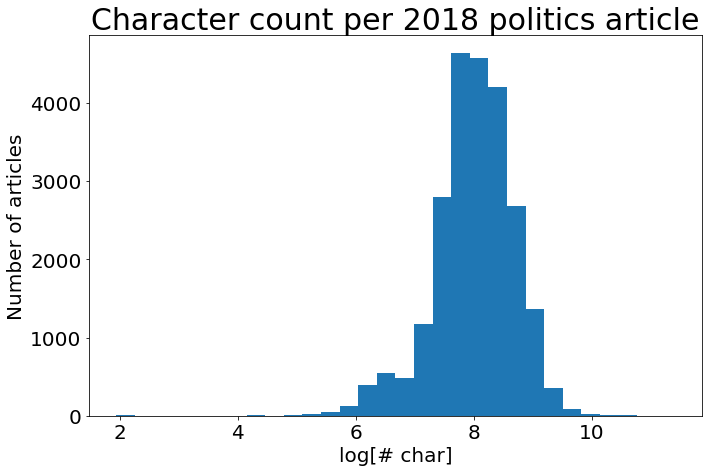

In [41]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2018 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

ax.hist(np.log(df_politics_2018.article.str.len()), bins=30);

In [42]:
article_lengths = df_politics_2018.article.str.len().sort_values()
article_lengths

3668         7
4132         7
13715        7
2016         7
10632        7
         ...  
21270    46656
8893     52341
12014    55859
11043    87399
3670     89310
Name: article, Length: 23546, dtype: int64

The longest articles seem to correspond to transcripts.

In [44]:
df_politics_2018.iloc[article_lengths.index[-10:]]

,id,date,year,month,day,author,title,article,url,section,publication
20701,1552458,2018-07-12,2018,7,12,,Tower of secrets: the Russian money behind a D...,"One October day in 2007, a celebrity real esta...",https://www.cnbc.com/2018/07/12/tower-of-secre...,Politics,CNBC
21894,1572053,2018-10-17 00:00:00,2018,10,17,,Read the transcript of AP's interview with Pre...,"In an interview with the Associated Press, Pre...",https://www.cnbc.com/2018/10/17/read-the-trans...,Politics,CNBC
2444,947838,2018-01-20,2018,1,20,Stephen Collinson,A year of Trump: (Almost) everything that happ...,Washington (CNN)It will be impossible to adequ...,https://www.cnn.com/2018/01/20/politics/everyt...,politics,CNN
8843,967915,2018-07-16,2018,7,16,,Transcript of Trump-Putin news conference,(CNN)US President Donald Trump held a joint n...,https://www.cnn.com/2018/07/16/politics/trump-...,politics,CNN
4544,956568,2018-03-15,2018,3,15,John D. Sutter,Puerto Ricans are still dying in Hurricane Mar...,"Maunabo, Puerto Rico (CNN)Lourdes Rodriguez he...",https://www.cnn.com/2018/03/15/politics/puerto...,politics,CNN
21270,1561529,2018-08-29 00:00:00,2018,8,29,,How the Trump administration went easy on smal...,"On a chilly morning in December 2016, 12-year-...",https://www.cnbc.com/2018/08/29/how-the-trump-...,Politics,CNBC
8893,968146,2018-07-17,2018,7,17,,Transcript: Obama's full speech about the 'pol...,(CNN)Former President Barack Obama spoke in J...,https://www.cnn.com/2018/07/17/politics/barack...,politics,CNN
12014,985621,2018-10-26,2018,10,26,Marshall Cohen,48 hours fact checking Trump,"As the midterm elections draw closer, Preside...",https://www.cnn.com/2018/10/26/politics/trump-...,politics,CNN
11043,979435,2018-09-27,2018,9,27,,Trump White House transcript test,Transcript of President Trump's press conferen...,https://www.cnn.com/2018/09/27/politics/transc...,politics,CNN
3670,953664,2018-02-22,2018,2,22,,"CNN town hall: Students question lawmakers, NR...",(CNN)Survivors of the massacre at Stoneman Do...,https://www.cnn.com/2018/02/22/politics/cnn-to...,politics,CNN


The shortest articles seem to corresponded to corrupted articles.

In [45]:
df_politics_2018.iloc[article_lengths.index[:10]]

,id,date,year,month,day,author,title,article,url,section,publication
3668,953658,2018-02-22,2018,2,22,,Read the indictment of Missouri Gov. Eric Grei...,(CNN),https://www.cnn.com/2018/02/22/politics/eric-g...,politics,CNN
4132,955673,2018-03-06,2018,3,6,,READ: Porn star Stormy Daniels' lawsuit agains...,(CNN),https://www.cnn.com/2018/03/06/politics/stormy...,politics,CNN
13715,997041,2018-12-20,2018,12,20,,READ: New continuing resolution bill heading t...,(CNN),https://www.cnn.com/2018/12/20/politics/new-co...,politics,CNN
2016,945910,2018-01-09,2018,1,9,Meg Wagner,Live updates: Steve Bannon out at Breitbart,(CNN),https://www.cnn.com/2018/01/09/politics/bannon...,politics,CNN
10632,977388,2018-09-14,2018,9,14,,READ: Paul Manafort's plea,(CNN),https://www.cnn.com/2018/09/14/politics/paul-m...,politics,CNN
4740,956977,2018-03-21,2018,3,21,,"Read the 2,232-page omnibus spending bill",(CNN),https://www.cnn.com/2018/03/21/politics/omnibu...,politics,CNN
4676,956853,2018-03-20,2018,3,20,,READ: Stormy Daniels' polygraph report,(CNN),https://www.cnn.com/2018/03/20/politics/stormy...,politics,CNN
3665,953648,2018-02-22,2018,2,22,,Read the new indictment of Paul Manafort and R...,(CNN),https://www.cnn.com/2018/02/22/politics/manafo...,politics,CNN
2264,947059,2018-01-16,2018,1,16,,READ: President Trump's physical exam report,(CNN),https://www.cnn.com/2018/01/16/politics/read-d...,politics,CNN
13316,994507,2018-12-07,2018,12,7,,READ: Special counsel Robert Mueller's filing ...,(CNN),https://www.cnn.com/2018/12/07/politics/muelle...,politics,CNN


Based on the above distribution of article lengths, we can assume that articles with $\le e^6$ characters ($\approx 80$ words) are likely corrupted or too short and will be dropped.

In [46]:
df_politics_2018 = df_politics_2018[df_politics_2018.article.str.len() > int(np.exp(6))]
df_politics_2018.reset_index(drop=True, inplace=True)

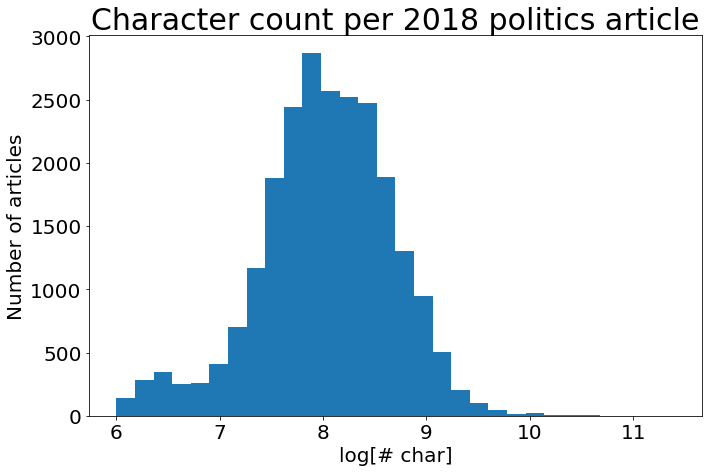

In [71]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2018 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

plt.hist(np.log(df_politics_2018.article.str.len()), bins=30);

---

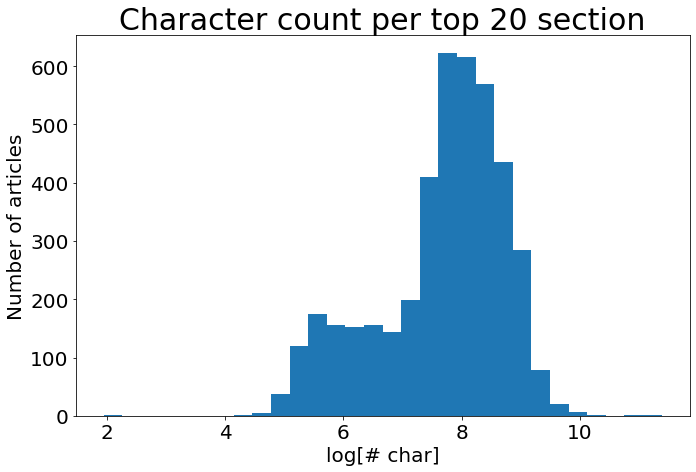

In [90]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per top 20 section")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

ax.hist(np.log(df_top_20.article.str.len()), bins=30);

In [91]:
article_lengths = df_top_20.article.str.len().sort_values()
article_lengths

986         7
1648       82
1718       93
221       109
3206      109
        ...  
3434    20890
1141    26954
3529    33766
1222    52341
863     87399
Name: article, Length: 4189, dtype: int64

In [92]:
df_top_20.iloc[article_lengths.index[-10:]]

,id,date,year,month,day,author,title,article,url,section,publication
3548,2088411,2018-03-22 07:49:24,2018,3,22,,What’s Next for Stocks After the China Tariffs...,Good Thursday Here’s what we’re watching: • Ta...,https://www.nytimes.com/2018/03/22/business/de...,business,The New York Times
3524,2083812,2018-02-13 07:10:42,2018,2,13,,Will Market Volatility Help Goldman Get Its Gr...,Happy Tuesday. Here’s what we’re watching: • M...,https://www.nytimes.com/2018/02/13/business/de...,business,The New York Times
2564,1528662,2018-03-16,2018,3,16,,ProPublica correction on Trump CIA pick waterb...,ProPublica says it erred when it reported in 2...,https://www.cnbc.com/2018/03/16/propublica-cor...,Politics,CNBC
4026,1547148,2018-06-13,2018,6,13,,Netflix: Why AT&T bought Time Warner and Comca...,The media industry is in a frenzy. AT&T is buy...,https://www.cnbc.com/2018/06/13/netflix-why-at...,Tech,CNBC
4113,2116339,2018-10-11 17:00:04,2018,10,11,,21 Art Exhibitions to View in N.Y.C. This Weekend,Our guide to new art shows and some that will ...,https://www.nytimes.com/2018/10/11/arts/design...,arts,The New York Times
3434,2120190,2018-10-12 05:00:11,2018,10,12,Sheila Marikar,The Transformational Bliss of Borrowing Your O...,Rent the Runway’s Unlimited service saves work...,https://www.nytimes.com/2018/10/12/business/re...,business,The New York Times
1141,959412,2018-04-20,2018,4,20,John D. Sutter,They fled Maria in Puerto Rico; now they're in...,"Kissimmee, Florida (CNN)With no running water,...",https://www.cnn.com/2018/04/20/politics/sutter...,politics,CNN
3529,1356506,2018-10-15,2018,10,15,WIRED Staff,Blue Origin and Jeff Bezos Want Us All to Leav...,It’s July 17 and the temperature in the West T...,https://www.wired.com/story/jeff-bezos-blue-or...,business,Wired
1222,968146,2018-07-17,2018,7,17,,Transcript: Obama's full speech about the 'pol...,(CNN)Former President Barack Obama spoke in J...,https://www.cnn.com/2018/07/17/politics/barack...,politics,CNN
863,979435,2018-09-27,2018,9,27,,Trump White House transcript test,Transcript of President Trump's press conferen...,https://www.cnn.com/2018/09/27/politics/transc...,politics,CNN


In [93]:
df_top_20.iloc[article_lengths.index[:10]]

,id,date,year,month,day,author,title,article,url,section,publication
986,953648,2018-02-22,2018,2,22,,Read the new indictment of Paul Manafort and R...,(CNN),https://www.cnn.com/2018/02/22/politics/manafo...,politics,CNN
1648,1191770,2018-04-25,2018,4,25,,Turkish central bank hikes late liquidity wind...,"ISTANBUL, April 25 (Reuters) - For full story,...",https://www.reuters.com/article/turkey-cenbank...,Bonds News,Reuters
1718,921610,2018-03-29,2018,3,29,,BRIEF-Fitch Affirms Morocco At 'Bbb-' Outlook ...,March 29 (Reuters) - * FITCH AFFIRMS MOROCCO A...,https://www.reuters.com/article/brief-fitch-af...,Bonds News,Reuters
221,397747,2018-06-07 00:00:00,2018,6,7,,Russian President Putin takes questions in ann...,For quotes from Russian President Vladimir Put...,https://www.reuters.com/article/us-russia-puti...,World News,Reuters
3206,532216,2018-04-19 00:00:00,2018,4,19,,BRIEF-Ibersol Proposes Gross Dividend Of 0.10 ...,April 19 (Reuters) - Ibersol SGPS SA: Source t...,https://www.reuters.com/article/brief-ibersol-...,Consumer Goods and Retail,Reuters
75,752857,2018-02-08 00:00:00,2018,2,8,,BRIEF-Blackline Safety Posts Q4 Loss Per Share...,Feb 8 (Reuters) - Blackline Safety Corp: * QTR...,https://www.reuters.com/article/brief-blacklin...,Market News,Reuters
2779,246097,2018-02-23 00:00:00,2018,2,23,,BRIEF-Integrum Appoints Carl Ekvall New CEO,Feb 23 (Reuters) - Integrum Ab: * CARL EKVALL ...,https://www.reuters.com/article/brief-integrum...,Healthcare,Reuters
25,822636,2018-03-01 00:00:00,2018,3,1,,BRIEF-Equifax Q4 Adjusted Earnings Per Share $...,March 1 (Reuters) - Equifax Inc: * Q4 ADJUSTED...,https://www.reuters.com/article/brief-equifax-...,Market News,Reuters
1763,1221983,2018-02-27,2018,2,27,,BRIEF-Bank Of Canada to auction C$2 bln of 5-D...,Feb 27 (Reuters) - * BANK OF CANADA TO AUCTION...,https://www.reuters.com/article/brief-bank-of-...,Bonds News,Reuters
493,823527,2018-02-02 00:00:00,2018,2,2,,BRIEF-Metrovacesa IPO Bookrunner Says ‍Books A...,Feb 2 (Reuters) - METROVACESA IPO BOOKRUNNER: ...,https://www.reuters.com/article/brief-metrovac...,Financials,Reuters


In [94]:
df_top_20 = df_top_20[df_top_20.article.str.len() > int(np.exp(6))]
df_top_20.reset_index(drop=True, inplace=True)

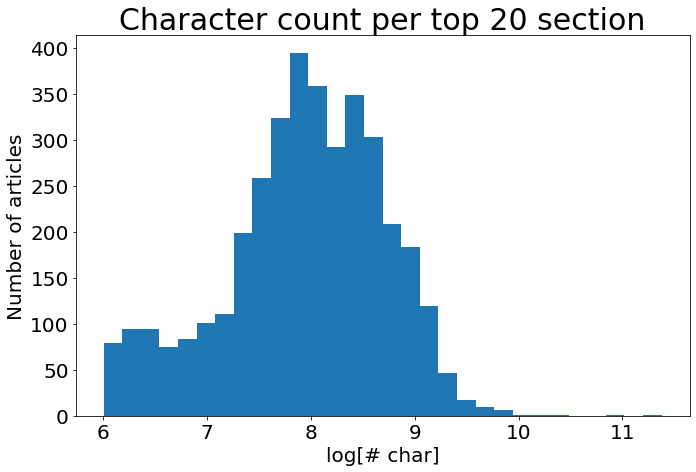

In [95]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per top 20 section")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

plt.hist(np.log(df_top_20.article.str.len()), bins=30);

---

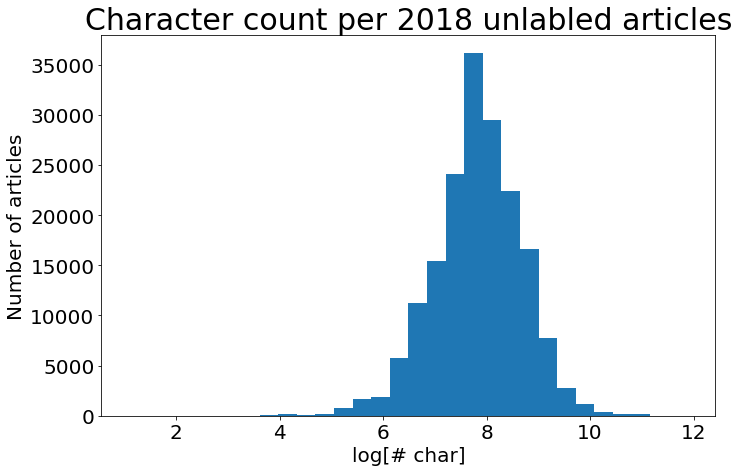

In [72]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2018 unlabled articles")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

ax.hist(np.log(df_unk.article.str.len()), bins=30);

In [73]:
article_lengths = df_unk.article.str.len().sort_values()
article_lengths

87033          3
70019          8
103032        10
170391        15
173024        19
           ...  
3881       98876
176268    101057
123774    118828
25486     120519
174481    144427
Name: article, Length: 178277, dtype: int64

In [74]:
df_unk.iloc[article_lengths.index[-10:]]

,id,date,year,month,day,author,title,article,url,section,publication
16393,109577,2018-12-07 17:43:59,2018,12,7,Eric Johnson,"Full Q&A: NBC journalists Chuck Todd, Andrea M...",The latest episode of Recode Decode with Kara ...,https://www.vox.com/2018/12/5/18127884/nbc-msn...,,Vox
12582,84013,2018-03-22 21:59:28,2018,3,22,Recode Staff,Full transcript: Former White House communicat...,"On this episode of Recode Decode, hosted by Ka...",https://www.vox.com/2018/3/22/17153620/transcr...,,Vox
13878,92889,2018-12-10 20:48:11,2018,12,10,Eric Johnson,Full Q&A: Y Combinator’s Sam Altman and Recode...,"On a recent episode of Recode Decode, Y Combin...",https://www.vox.com/2018/12/10/18134926/sam-al...,,Vox
170207,1929998,2018-02-15 00:00:00,2018,2,15,BuzzFeed News,The Latest: Students Resume Classes At Marjory...,People wait in line to visit Marjory Stoneman ...,https://www.buzzfeednews.com/article/buzzfeedn...,,Buzzfeed News
176204,1936008,2018-11-09 00:00:00,2018,11,9,BuzzFeed News,California Camp Fire Now 100% Contained After ...,A family searches through the ashes of their b...,https://www.buzzfeednews.com/article/buzzfeedn...,,Buzzfeed News
3881,26168,2018-12-12 15:14:00,2018,12,12,Eric Johnson,Full Q&A: Ezra Klein and Kara Swisher on the f...,"On the latest episode of Recode Decode, we ret...",https://www.vox.com/2018/12/12/18136726/ezra-k...,,Vox
176268,1936072,2018-11-06 00:00:00,2018,11,6,BuzzFeed News,Midterm Elections Live Results: Democrats Have...,"Ilhan Omar Congressman Duncan Hunter, a Califo...",https://www.buzzfeednews.com/article/buzzfeedn...,,Buzzfeed News
123774,1787128,2018-01-19,2018,1,19,The Hill Staff,The Trump Presidency: Year One | TheHill,"One year ago Saturday, Donald J. Trump was swo...",https://thehill.com/homenews/administration/36...,,The Hill
25486,171048,2018-04-10 03:33:24,2018,4,10,Ezra Klein,The Sam Harris-Ezra Klein debate,"There’s a lot of backstory to this podcast, wh...",https://www.vox.com/2018/4/9/17210248/sam-harr...,,Vox
174481,1934280,2018-08-27 00:00:00,2018,8,27,Christine Kenneally,We Saw Nuns Kill Children: The Ghosts of St. J...,"It was a late summer afternoon, Sally Dale rec...",https://www.buzzfeednews.com/article/christine...,,Buzzfeed News


In [75]:
df_unk.iloc[article_lengths.index[:10]]

,id,date,year,month,day,author,title,article,url,section,publication
87033,848218,2018-04-19 00:00:00,2018,4,19,Matt Novak,"So, How's InfoWars Doing?",Oh.,https://gizmodo.com/so-hows-infowars-doing-182...,,Gizmodo
70019,470242,2018-08-29 00:00:00,2018,8,29,Alexandra Shystman,Multipop Test Story,mJeRoY2Z,https://www.refinery29.com/en-us/multipop-test,,Refinery 29
103032,1538024,2018-05-01,2018,5,1,,"Food, photos, music: Millennial stocks could s...",Disclaimer,https://www.cnbc.com/2018/04/30/food-photos-mu...,,CNBC
170391,1930182,2018-02-23 00:00:00,2018,2,23,Cora Lewis,Trump Just Delivered A Speech Transporting Us ...,Trump in Biloxi,https://www.buzzfeednews.com/article/coralewis...,,Buzzfeed News
173024,1932821,2018-06-29 00:00:00,2018,6,29,David Mack,"Well, Fuck Me! Marco Rubio Is Mad The Media Is...",I fucking told you!,https://www.buzzfeednews.com/article/davidmack...,,Buzzfeed News
14874,99528,2018-04-12 00:00:00,2018,4,12,Steven Weinberg,It Seems Like This:,Distance is relative.,https://hyperallergic.com/437479/it-seems-like...,,Hyperallergic
4388,29514,2018-07-21 00:00:00,2018,7,21,,P.O.V. Bikini Selfies -- Guess Who!,It's all about angles!,https://www.tmz.com/2018/07/21/pov-bikini-self...,,TMZ
172124,1931920,2018-05-22 00:00:00,2018,5,22,Krystie Lee Yandoli,Charlize Theron Is Playing Megyn Kelly In A Ne...,Ailes died in May 2017.,https://www.buzzfeednews.com/article/krystieya...,,Buzzfeed News
173473,1933271,2018-07-21 00:00:00,2018,7,21,BuzzFeed News,Future History 1968: The Beatles Go To India,Produced by 1968.Digital.,https://www.buzzfeednews.com/article/buzzfeedn...,,Buzzfeed News
173195,1932993,2018-07-08 00:00:00,2018,7,8,BuzzFeed News,Future History 1968: Nuclear Physicist Andrei ...,Produced by 1968.digital.,https://www.buzzfeednews.com/article/buzzfeedn...,,Buzzfeed News


In [76]:
df_unk = df_unk[df_unk.article.str.len() > int(np.exp(6))]
df_unk.reset_index(drop=True, inplace=True)

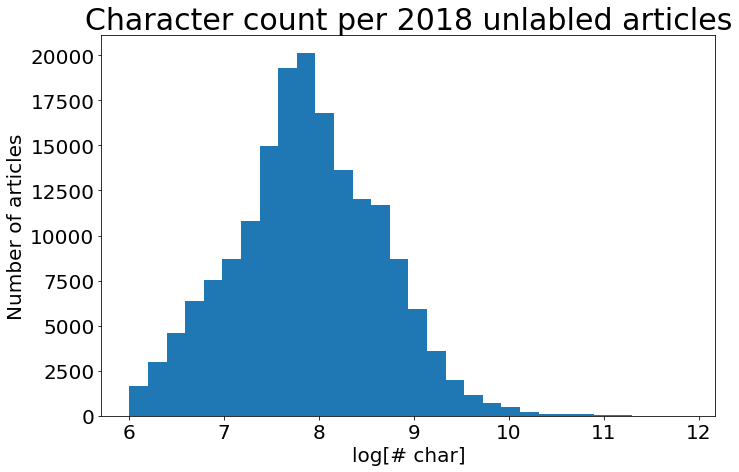

In [77]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2018 unlabled articles")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

plt.hist(np.log(df_unk.article.str.len()), bins=30);

---

# Random forest classifier

We will build a random forest classifier trained on the labeled section and use that to create labels for our unlabeled dataset.

We have to do a bit more preprocessing for the classifier:
- Make each section lower case so politics and Politics are the same
- One-hot encode the section so that 0 = not politics and 1 = politics

In [96]:
df_top_20["section"] = df_top_20["section"].apply(lambda s: s.lower())
df_top_20["is_politics"] = 1 * (df_top_20.section == "politics")
df_top_20.is_politics.value_counts()

0    2022
1    1690
Name: is_politics, dtype: int64

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_top_20.article, df_top_20.is_politics, random_state=4567, test_size=0.2, stratify=df_top_20.is_politics)

In [102]:
val_accs = []
train_accs = []
cm = []
n_ests = [10, 50, 100, 150, 200, 250]

tfidf_train = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=5, max_df=0.7)
X_train_tr = tfidf_train.fit_transform(X_train)
X_test_tr = tfidf_train.transform(X_test)

for n in n_ests:                 
    rfc = RandomForestClassifier(n_estimators=n, random_state=2375)

    rfc.fit(X_train_tr, y_train)
    y_pred_train = rfc.predict(X_train_tr)
    train_accs.append(accuracy_score(y_train, y_pred_train))

    y_pred = rfc.predict(X_test_tr)
    val_accs.append(accuracy_score(y_test, y_pred))
    cm.append(confusion_matrix(y_test, y_pred))

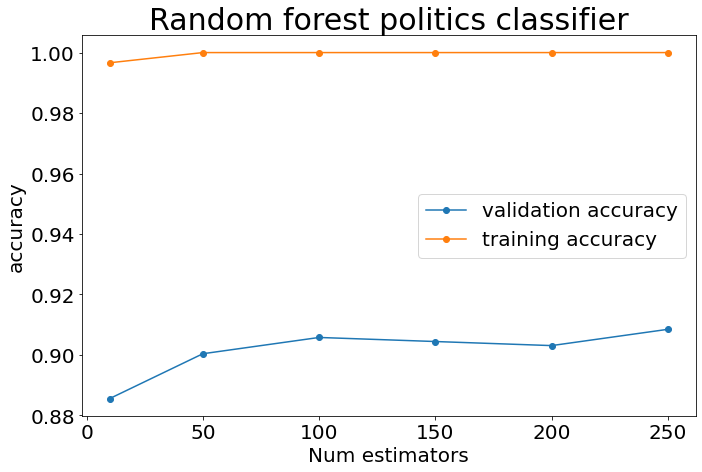

In [124]:
plt.figure(figsize=(11,7))

plt.title("Random forest politics classifier")
plt.xlabel("Num estimators")
plt.ylabel("accuracy")

plt.plot(n_ests, val_accs, marker="o", label="validation accuracy")
plt.plot(n_ests, train_accs, marker="o", label="training accuracy")

plt.legend(fontsize=20)

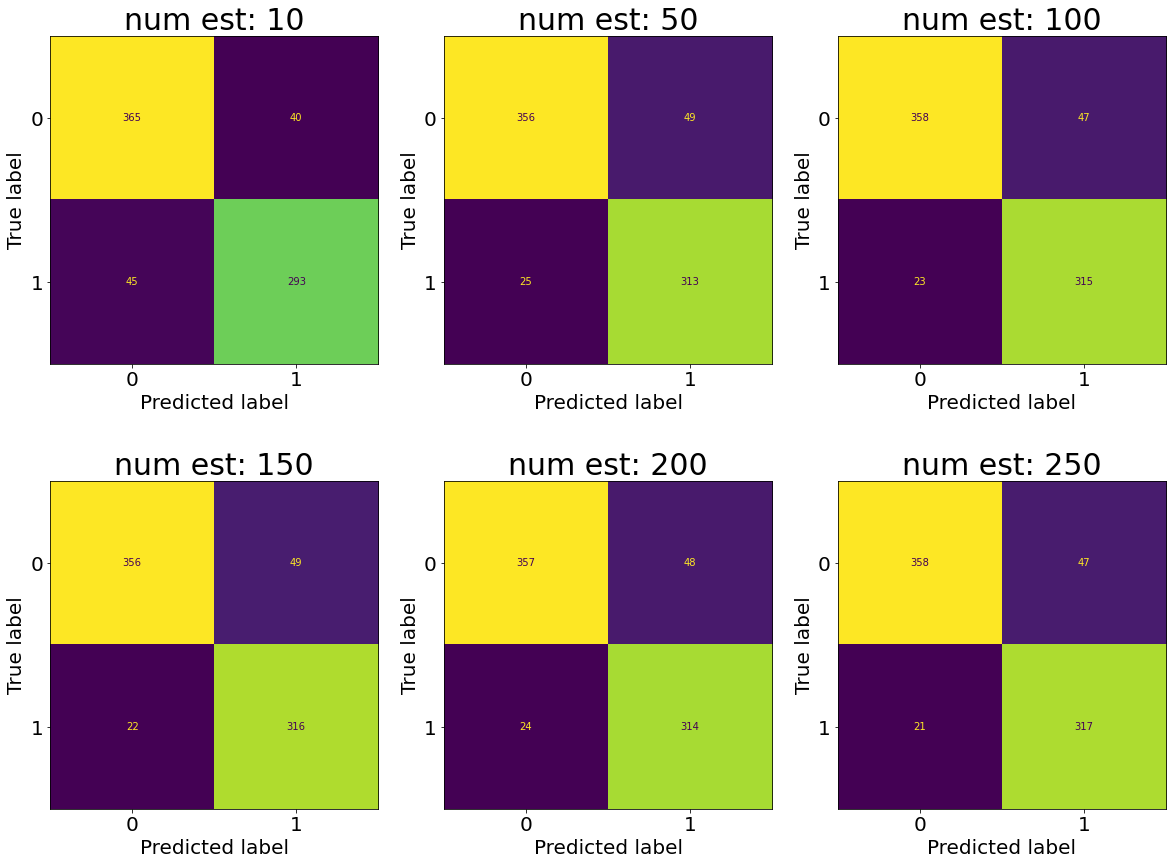

In [121]:
fig, axs = plt.subplots(2,3, figsize=(20, 15))

for i, n in enumerate(n_ests):
    r = i // 3
    c = i % 3
    
    axs[r, c].set_title("num est: %d" % n)
    #axs[r, c].imshow(cm[i])
    ConfusionMatrixDisplay(confusion_matrix=cm[i]).plot(ax=axs[r,c], colorbar=False)

The random forest model with 100 estimators performs sufficiently well for our needs. It has a 90% accuracy on the validation set and low number of false positives/negatives.

We will train the random forest classifier with 100 estimators on the full dataset.

In [125]:
tfidf_class = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=5, max_df=0.7)
X_class_tr = tfidf_class.fit_transform(df_top_20.article)

RandomForestClassifier(random_state=56454)

In [128]:
rfc_final = RandomForestClassifier(n_estimators=100, random_state=56454)
rfc_final.fit(X_class_tr, df_top_20.is_politics)

RandomForestClassifier(random_state=56454)

In [139]:
#dump(rfc_final, 'rfc_final.joblib') 

Checking a random sample of 20 articles we see the model is performing well.

In [126]:
df_unk.sample(20, random_state=456).article

124601    House Minority Leader Nancy PelosiNancy Pelosi...
125686    The Senate on Thursday voted to confirm Presid...
71024     There are some Halloween episodes that will fo...
136658    The White House on Tuesday indicated it wants ...
116410    Someone needs to inform @realdonaldtrump that ...
32686     Adobe currently has three dozens apps in the A...
63659     Facebook’s status update box is getting a new ...
29370     Kendall Jenner is lots of things for sure, inc...
22420     Even in these early stages of development, the...
14872     Russell Westbrook had touched down in Denver -...
37286     The Housing and Urban Development Department, ...
145338       Hill.TV host Krystal Ball and conservative ...
142718    Comedian Jon Stewart tore into President Trump...
5891      President Donald Trump doesn’t like to talk ab...
141047    House Minority Leader Nancy PelosiNancy Pelosi...
7591      Two years ago, Bernie Sanders wasn’t heading a...
108338    An Illinois county has adopted

In [131]:
rfc_final.predict(tfidf_class.transform(df_unk.sample(20, random_state=456).article))

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

Let's classify the full unknown dataset.

In [132]:
X_unk_tr = tfidf_class.transform(df_unk.article)

In [137]:
#dump(X_unk_tr, 'X_unk_tr.joblib')

In [140]:
df_unk["is_politics"] = rfc_final.predict(X_unk_tr)

There are over 71k politics articles in the unlabeled dataset

In [144]:
df_unk.is_politics.value_counts()

0    102685
1     71635
Name: is_politics, dtype: int64

Let's combine the new politics articles with the originally labeled politics articles

In [178]:
df_all_politics = pd.concat([df_politics_2018, df_unk[df_unk.is_politics == 1]])
df_all_politics.drop(["section", "is_politics"], axis=1, inplace=True)

In [179]:
df_all_politics.head()

,id,date,year,month,day,author,title,article,url,publication
0,10809,2018-01-29 20:50:00,2018,1,29,"Caroline Tompkins, Eve Peyser",David Frum Is a Political Party of One,Though Frum spends his days decrying Donald Tr...,https://www.vice.com/en_us/article/7xeg84/davi...,Vice
1,28720,2018-09-10 18:18:00,2018,9,10,"Elizabeth Renstrom, Eve Peyser",Cynthia Nixon on Her Run for Governor and What...,A decade after Nixon's iconic role as Miranda ...,https://www.vice.com/en_us/article/wjyqq4/cynt...,Vice
2,29160,2018-03-13 18:52:00,2018,3,13,Marcy Wheeler,The Republican Russia Investigation Circus Kee...,If last week’s Russia investigation-related fi...,https://www.vice.com/en_us/article/pamjx9/the-...,Vice
3,31867,2018-02-05 22:00:00,2018,2,5,Eve Peyser,"Get to Know 'Little' Adam Schiff, Trump's Late...","I am dying to know how tall Adam Schiff is, bu...",https://www.vice.com/en_us/article/7x79zb/get-...,Vice
4,32906,2018-05-18 20:35:00,2018,5,18,Eve Peyser,The Onion’s Brutal Israel Commentary Goes Beyo...,Supporters of Palestinians were outraged. “Eve...,https://www.vice.com/en_us/article/kzkwzy/the-...,Vice


---

<BarContainer object of 23 artists>

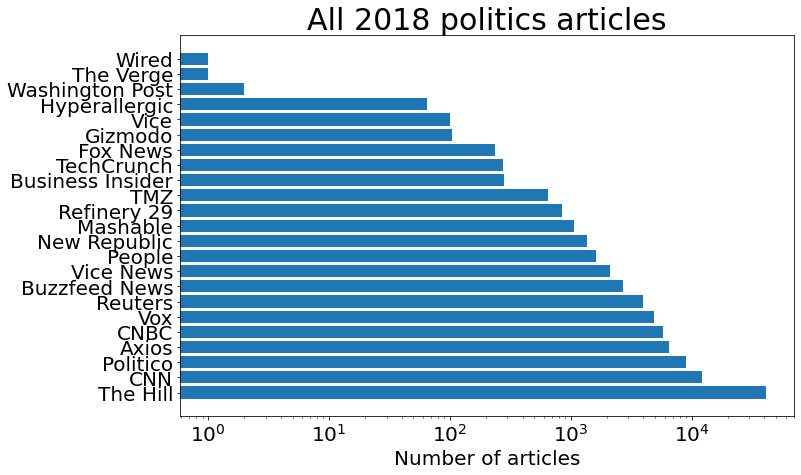

In [155]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("All 2018 politics articles")
ax.set_xlabel("Number of articles")

ax.barh(df_all_politics.groupby("publication").count().sort_values(by="id", ascending=False).index, width=df_all_politics.groupby("publication").count().sort_values(by="id", ascending=False)["id"], log=True)

---

# Topic modeling

In [156]:
tfidf_all_politics = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=5, max_df=0.7)
vectors_all_politics = tfidf_all_politics.fit_transform(df_all_politics["article"])

In [161]:
#dump(vectors_all_politics, 'vectors_all_politics.joblib')

# Non-negative matrix factorization (NMF)

Non-negative matrix factorization (NMF) is an algorithm for approximating a matrix $V$ with a low rank matrix $WH$ so that $V \approx W H$.
Typically the quality of the approximation is measured by using the Frobenius norm as a measure of the error.
When the error is instead measured by the Kullback–Leibler divergence, NMF is identical to the probabilistic latent semantic analysis (PLSA).

NMF is commonly used in topic modeling since the non-negative entries of all matrices make it easy to interpret. Pictorially the procedure is shown below.

<center>
<figure>
<img src="nmf_decomp.png" style="width:50%">
<figcaption align = "center"> Adapted from Blueprints for Text Analytics Using Python: Machine Learning-Based Solutions for Common Real World (NLP) Applications </figcaption>
</figure>
</center>

For a given document-word matrix $V$ where the documents are the rows and the columns correspond to the frequency of words appearing in each document (e.g. measured using TF-IDF), the NMF decomposition results in the matrices $W$ and $H$. The rows of $W$ correspond to the features in each document and the columns of $H$ correspond to the words in each feature. This lends to the interpretation of each of the features as a "topic". After factorization, we can assign a topic to each document based on the largest value in each row of $W$.

In [157]:
nmf_all_politics = NMF(n_components=15, random_state=43, alpha_W=0.0, alpha_H="same")
W_mat = nmf_all_politics.fit_transform(vectors_all_politics)
H_mat = nmf_all_politics.components_

In [158]:
df_all_politics["topic"] = np.argmax(W_mat, axis=1)

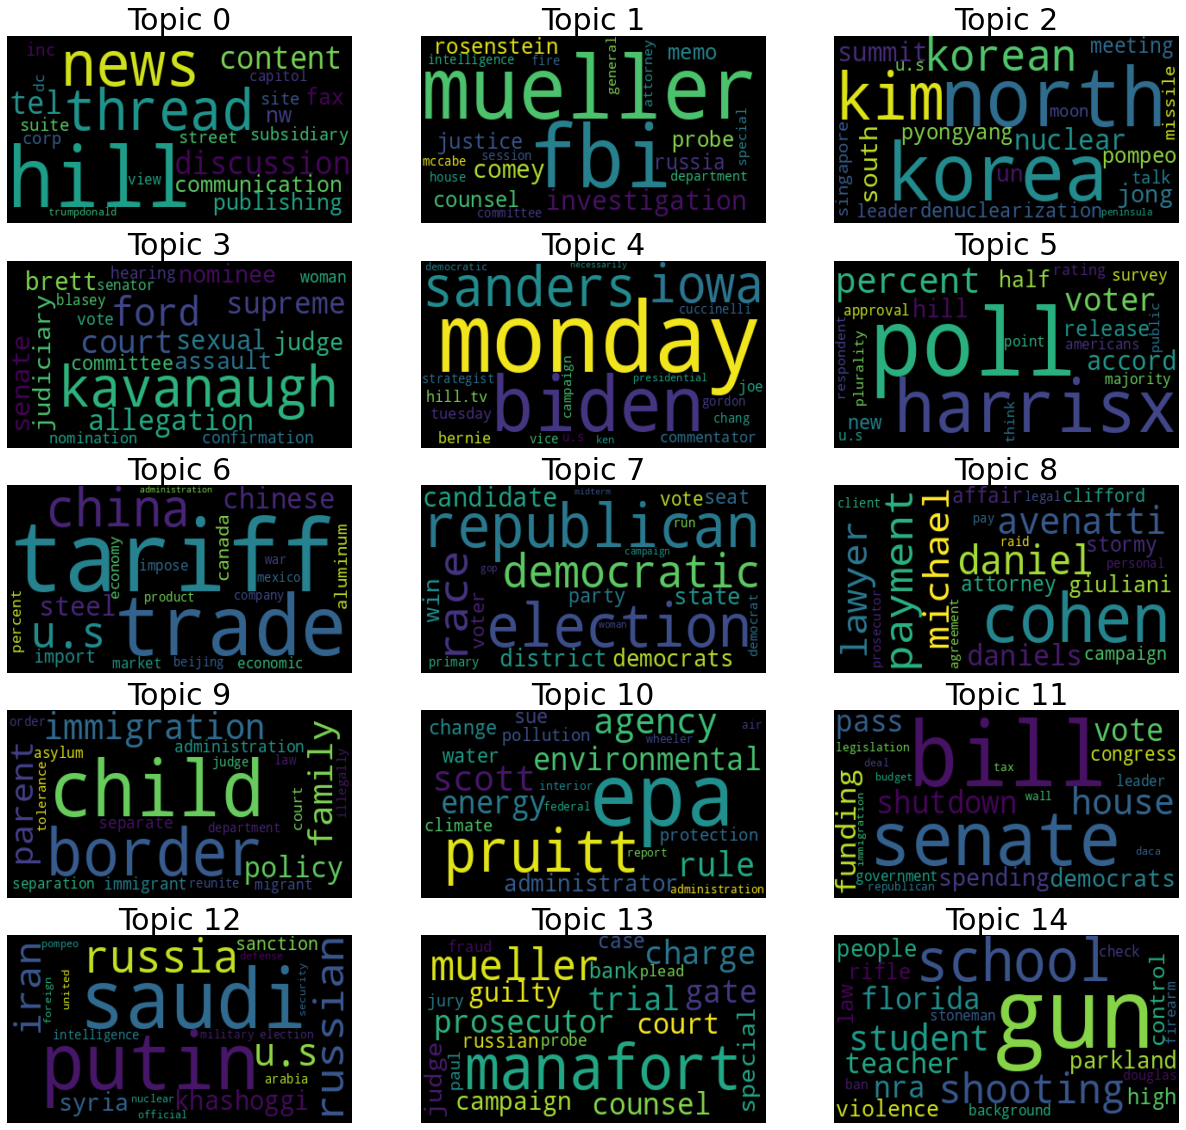

In [163]:
fig, axs = plt.subplots(5,3, figsize=(21,20))

words = tfidf_all_politics.get_feature_names_out()
for topic, weights in enumerate(H_mat):
        largest = weights.argsort()[::-1]
        d = {}
        for i in range(20):
            d[words[largest[i]]] = weights[largest[i]]

        wocl = WordCloud()
        wocl.generate_from_frequencies(d)
        
        axs[topic//3, topic%3].set_title("Topic %d" % topic)
        axs[topic//3, topic%3].imshow(wocl, aspect='auto', interpolation='bilinear')
        axs[topic//3, topic%3].axis("off")

In [229]:
topic_dict = {
    0:  "0",
    1:  "russia investigation",
    2:  "nuclear summit",
    3:  "kavanaugh",
    4:  "bernie sanders",
    5:  "polls",
    6:  "steel tariff",
    7:  "election",
    8:  "stormy daniels",
    9:  "immigration policy",
    10: "epa",
    11: "government shutdown",
    12: "khashoggi",
    13: "paul manafort",
    14: "parkland shooting"
}

<BarContainer object of 15 artists>

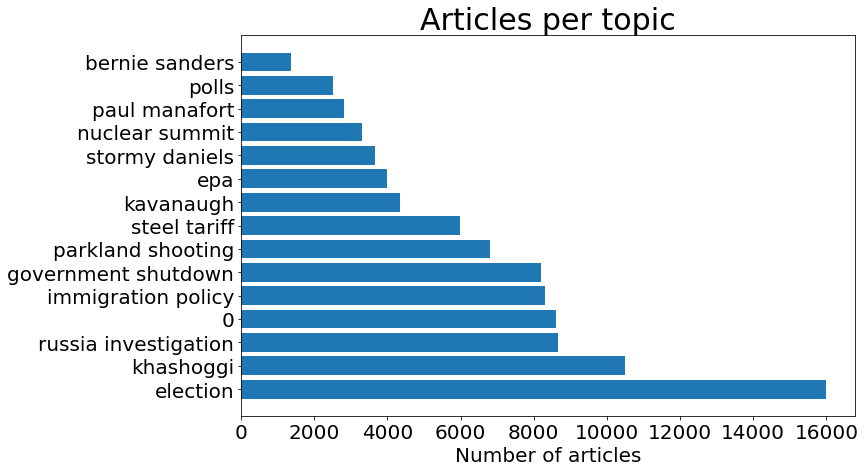

In [230]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Articles per topic")
ax.set_xlabel("Number of articles")

ax.barh([topic_dict[i] for i in df_all_politics.topic.value_counts().index.values], df_all_politics.topic.value_counts())

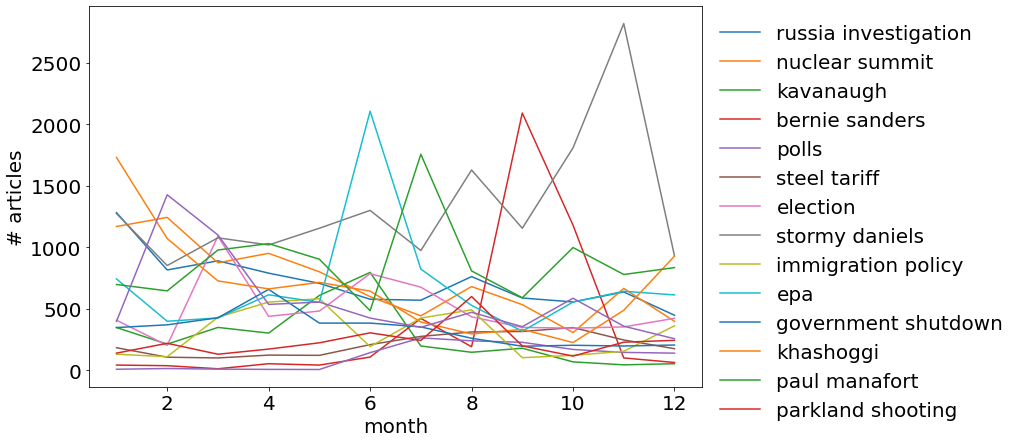

In [235]:
fig, ax = plt.subplots(figsize=(11,7))

df_all_politics.groupby(["month", "topic"]).count().unstack()["id"].plot(ax=ax)

ax.set_ylabel("# articles")
ax.set_xlabel("month")

plt.legend(labels=[topic_dict[i] for i in range(1,15)],
           fontsize=20, frameon=False, bbox_to_anchor=(1, 1, 0, 0))

In [237]:
#df_all_politics.to_csv("df_all_politics.csv")